# アニメデータセットを準備する

In [1]:
ANIMEFACE_DATASET_URL = "http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip"
FOLDER_PATH = "../../datasets/animeface/"

In [2]:
import sys
sys.path.append("../utils")

In [3]:
from datasets import unzip_download_data
unzip_file_path = unzip_download_data(ANIMEFACE_DATASET_URL, FOLDER_PATH)

In [4]:
unzip_file_path

'../../datasets/animeface/animeface-character-dataset'

In [5]:
%matplotlib inline
from matplotlib import pylab as plt
from PIL import Image

In [6]:
def reformat_image(file_name, save_name):
    img = Image.open(file_name)
    half_the_width = int(img.size[0] / 2)
    half_the_height =int(img.size[1] / 2)
    min_size = half_the_width
    if min_size > half_the_height:
        min_size = half_the_height

    half_mini_size = int(min_size)

    img = img.crop(
        (
            half_the_width - half_mini_size,
            half_the_height - half_mini_size,
            half_the_width + half_mini_size,
            half_the_height + half_mini_size
        )
    )
    img = img.resize((28,28))
    img.save(save_name)

In [7]:
import os
from os.path import join, relpath
from glob import glob
import numpy as np

In [8]:
thumb_path = unzip_file_path + "/thumb"
resize_path  = unzip_file_path + "/thumb28"
if not os.path.exists(resize_path):
    os.mkdir(resize_path)

In [9]:
folders = glob(join(thumb_path, '*'))
for folder in folders:
    resize_folder = folder.replace("thumb", "thumb28")
    if not os.path.exists(resize_folder):
        os.mkdir(resize_folder)
    for file in glob(join(folder, "*.png")):
        resize_file_name =  file.replace("thumb","thumb28")
        if not os.path.exists(resize_file_name):
            reformat_image(file, resize_file_name) 

In [10]:
def rgb_array(image):
    img_array = np.asarray(image) / 255
    r,g,b=[],[],[]
    for row in img_array:
        for col in row:
            r.append(col[0])
            g.append(col[1])
            b.append(col[2])
    img_rgb=[r,g,b]
    return img_rgb

In [11]:
def create_dataset(path, character_num=10) :
    imgs, flags = [], []
    i = 0
    for folder in glob(join(path, '*')):
        for file in glob(join(folder, '*.png')):
            imgs.append(rgb_array(Image.open(file)))
            flag = np.zeros(character_num)
            flag[i] = 1
            flags.append(flag)
        i += 1
        if i >= character_num :
            break 
                
    imgs = np.array(imgs).astype("float32")
    flags = np.array(flags).astype("int32")    
    return imgs, flags

In [12]:
def draw_rgb(data, size=28):
    data = data.reshape(3,28,28)
    data = data.transpose(1, 2, 0)*255
    pil_image = Image.fromarray(np.clip(data, 0, 255).astype(np.uint8))
    plt.imshow( pil_image )

In [13]:
imgs, flags = create_dataset(resize_path)

In [14]:
imgs[0]

array([[ 1.        ,  1.        ,  0.99607843, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.99607843,  0.99215686,  0.99607843, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.99607843,  0.99607843, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

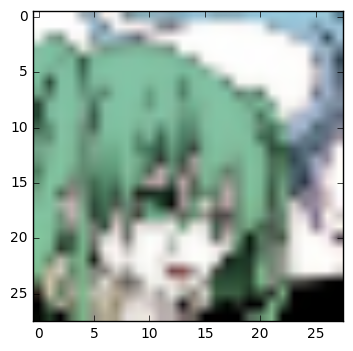

In [15]:
draw_rgb(imgs[0])

In [16]:
flags[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# 分類する

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_imgs, test_imgs, train_flags, test_flags = train_test_split(imgs, flags, test_size=0.1)

In [19]:
print(len(train_imgs), len(test_imgs))

851 95


In [20]:
class DataSet(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def next_batch(self, batch_size):
        batch_index = np.random.randint(len(self.x)-batch_size)
        batch_x =self.x[batch_index:batch_index+batch_size]
        batch_y = self.y[batch_index:batch_index+batch_size]
        return batch_x, batch_y

In [21]:
train = DataSet(train_imgs, train_flags)
test = DataSet(test_imgs, test_flags)

In [22]:
x,y = train.next_batch(10)
x[0]

array([[ 0.93725491,  0.92941177,  0.93333334, ...,  0.40392157,
         0.13725491,  0.32941177],
       [ 0.3882353 ,  0.35294119,  0.34117648, ...,  0.51764709,
         0.13725491,  0.43529412],
       [ 0.43921569,  0.41568628,  0.41568628, ...,  0.72156864,
         0.17254902,  0.65490198]], dtype=float32)

In [23]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [24]:
x = tf.placeholder(tf.float32, shape=[None, 3, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [25]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [26]:
x_image = tf.reshape(x, [-1,28,28,3])

In [27]:
# 最初の層は5x5のpatchにするので、32 featuresを作る
W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])

In [28]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [29]:
# 二層目 5x5のpatchで、64 featuresつくる inputは32
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

In [30]:
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
print(h_pool2) #　これでサイズ見れるの便利

Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)


In [31]:
# 最後に全結合のレイヤーを入れる 7*7*64 →1024
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [32]:
# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [33]:
# 出力層
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [34]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

In [35]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [36]:
for i in range(1000):
    batch = train.next_batch(100)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 0.8})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.1
step 100, training accuracy 0.48
step 200, training accuracy 0.82
step 300, training accuracy 0.9
step 400, training accuracy 0.88
step 500, training accuracy 0.95
step 600, training accuracy 0.99
step 700, training accuracy 0.99
step 800, training accuracy 1
step 900, training accuracy 1


In [37]:
print("test accuracy %g"%accuracy.eval(feed_dict={ x: test.x, y_: test.y, keep_prob: 1.0}))

test accuracy 0.8
